In [25]:
import pandas as pd
import numpy as np
import re
from pprint import pprint
import collections
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from keras import models
from keras import layers
import json
from nltk.corpus import stopwords

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import TfidfModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

import os

In [26]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['bully', 'bullying', 'httplink', 'mkr', 'im'])
print(stop_words)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [4]:
df = pd.read_csv('../text_twitter_raw.csv')
print(df['Label'].unique())

print(df.loc[df['Label'] == 'positive'])
print(df.loc[df['Label'] == 'negative'])


['negative' 'positive']
                                                    Text     Label
2      RT @username Call me sexist, but when I go to ...  positive
3      @username Wrong, ISIS follows the example of M...  positive
6      RT @username @username nooo not sexist but mos...  positive
9      RT @username There's something wrong when a gi...  positive
11     @username @username @username @username A good...  positive
...                                                  ...       ...
16832  RT @username Just don't find Woman comedians f...  positive
16834  RT @username I'm not sexist but I hate all fem...  positive
16836  @username Yes, all that Islam is making ISIS s...  positive
16841  yeah so annoying how they're doing their jobs ...  positive
16844  @username An enemy of @username is good enough...  positive

[5347 rows x 2 columns]
                                                    Text     Label
0      @username @username @username I read them in c...  negative
1      @usern

In [27]:
# Convert to list
data = df.Text.values.tolist()

#remove links
data = [re.sub(r"http\S+", "", sent) for sent in data]

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

['I read them in context.No change in meaning. The history of Islamic slavery. '
 'HTTPLINK']


In [6]:
from nltk.internals import config_java

os.environ['JAVAHOME'] = "C:/Program Files/Java/jdk1.8.0_161/bin/java.exe"
config_java('C:/Program Files/Java/jdk1.8.0_161/bin/java.exe')


english_nertagger = StanfordNERTagger('C:/Users/erajkovic/Anaconda3/Lib/site-packages/stanford-ner-2015-04-20/classifiers/english.conll.4class.distsim.crf.ser.gz', 'C:/Users/erajkovic/Anaconda3/Lib/site-packages/stanford-ner-2015-04-20/stanford-ner.jar')

NameError: name 'StanfordNERTagger' is not defined

In [42]:
from nltk.tag.stanford import StanfordNERTagger

#Set environmental variables programmatically.
#Set the classpath to the path where the jar file is located
os.environ['CLASSPATH'] = "C:/Users/erajkovic/Documents/APT/projekt/stanford-ner-2015-04-20/stanford-ner.jar"
#Set the Stanford models to the path where the models are stored
os.environ['STANFORD_MODELS'] = 'C:/Users/erajkovic/Documents/APT/projekt/stanford-corenlp-caseless-2015-04-20-models/edu/stanford/nlp/models/ner'
#Set the java jdk path

java_path = "C:/Program Files/Java/jdk1.8.0_161/bin/java.exe"
os.environ['JAVAHOME'] = java_path


#Set the path to the model that you would like to use
stanford_classifier  =  'C:/Users/erajkovic/Documents/APT/projekt/stanford-corenlp-caseless-2015-04-20-models/edu/stanford/nlp/models/ner/english.all.3class.caseless.distsim.crf.ser.gz'

#Build NER tagger object
st = StanfordNERTagger(stanford_classifier, "C:/Users/erajkovic/Documents/APT/projekt/stanford-ner-2015-04-20/stanford-ner.jar")

#A sample text for NER tagging
text = 'srinivas ramanujan went to the united kingdom. There he studied at cambridge university.'

#Tag the sentence and print output
tagged = st.tag(str(text).split())
print(tagged)


[('srinivas', 'PERSON'), ('ramanujan', 'PERSON'), ('went', 'O'), ('to', 'O'), ('the', 'O'), ('united', 'LOCATION'), ('kingdom.', 'LOCATION'), ('There', 'O'), ('he', 'O'), ('studied', 'O'), ('at', 'O'), ('cambridge', 'LOCATION'), ('university.', 'O')]


In [28]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=False))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['read', 'them', 'in', 'context', 'no', 'change', 'in', 'meaning', 'the', 'history', 'of', 'islamic', 'slavery', 'httplink']]


In [ ]:
def check_ner_tag(text, word):
    tagged = st.tag(text)
    for w, tag in tagged:
        if w == word:
            if tag == 'PERSON':
                return True
            else:
                return False
    return False

def remove_ner_person(texts):
    return [[word for word in doc if not check_ner_tag(doc, word)] for doc in texts]

data_words = remove_ner_person(data_words)

print(data_words[3:4])

In [29]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

C:\Users\erajkovic\Anaconda3\envs\tensorflow_env\lib\site-packages\gensim\models\phrases.py:494: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['read', 'them', 'in', 'context', 'no', 'change', 'in', 'meaning', 'the', 'history', 'of', 'islamic', 'slavery', 'httplink']


In [9]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in doc if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

def remove_no_dict_words(texts):
    return [[word for word in doc if word in glove_dict] for doc in texts]
    
GLOVE_DIM=100
glove_file = 'C:/Users/erajkovic/Downloads/glove.twitter.27B/glove.twitter.27B.100d.txt'
glove_dict = []
NB_WORDS = 4525   # duljina file-a vocab
glove = open(glove_file, encoding="utf8")
for line in glove:
    values = line.split()
    word = values[0]
    glove_dict.append(word)
glove.close()
print(glove_dict[:3])
    

['<user>', '.', ':']


In [30]:
# Remove Stop Words
data_words_nodict = remove_no_dict_words(data_words)
data_words_nostops = remove_stopwords(data_words_nodict)
print(data_words_nostops)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
data_lemmatized = remove_stopwords(data_lemmatized)


print(data_lemmatized[:1])


[['read', 'context', 'change', 'meaning', 'history', 'islamic', 'slavery'], ['idiots', 'claim', 'people', 'tried', 'stop', 'becoming', 'terrorist', 'made', 'terrorist', 'brain', 'dead'], ['rt', 'call', 'sexist', 'go', 'auto', 'place', 'id', 'rather', 'talk', 'guy'], ['wrong', 'isis', 'follows', 'example', 'mohammed', 'quran', 'exactly'], [], ['rt', 'saudi', 'preacher', 'raped', 'tortured', 'five', 'year', 'old', 'daughter', 'death', 'released'], ['rt', 'nooo', 'sexist', 'women', 'bad', 'drivers'], ['going', 'make', 'pancakes', 'dont', 'hve', 'strawberries', 'hve', 'bananas'], ['rt', 'dare', 'feelings', 'fantastic', 'way', 'dehumanize', 'someone'], ['rt', 'theres', 'something', 'wrong', 'girl', 'wins', 'wayne', 'rooney', 'street', 'striker'], ['shes', 'dont', 'run', 'blocking', 'manually'], ['good', 'muslim', 'good', 'despite', 'bad', 'religion'], ['help', 'everyone', 'asks', 'pass', 'judgment', 'anyone', 'comes', 'looking', 'help'], ['yeah', 'called', 'caring', 'human', 'life', 'idiot'

[['read', 'context', 'change', 'mean', 'history', 'islamic', 'slavery']]


In [31]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
tfidf = TfidfModel(corpus)
corpus = tfidf[corpus]

# View
print(corpus[:1])
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus]


[[('change', 0.3663481039921675),
  ('context', 0.48414416506219327),
  ('history', 0.38770635447001583),
  ('islamic', 0.3845196060542373),
  ('mean', 0.30118158574868104),
  ('read', 0.31020264629179073),
  ('slavery', 0.3824734239663198)],
 [('become', 0.322566322699122),
  ('brain', 0.35024449039717886),
  ('claim', 0.29419436234820473),
  ('dead', 0.3273388073789361),
  ('idiot', 0.28586075171556363),
  ('make', 0.18560720288560234),
  ('people', 0.18620795071719973),
  ('stop', 0.24609933711130463),
  ('terrorist', 0.558882910492497),
  ('try', 0.23627092783743794)],
 [('auto', 0.5132502774110147),
  ('call', 0.24697208739746004),
  ('go', 0.19892090811523686),
  ('guy', 0.3004558657368437),
  ('id_rather', 0.5132502774110147),
  ('place', 0.355549040032735),
  ('rt', 0.21638584027244212),
  ('sexist', 0.18495157314979646),
  ('talk', 0.2736143315532153)],
 [('exactly', 0.42234698859930714),
  ('example', 0.4395381683951668),
  ('follow', 0.37977444004175953),
  ('isis', 0.284155

In [32]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=2, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=100,
                                           alpha='auto',
                                           per_word_topics=False)

In [33]:
# Print the Keyword in the n topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.009*"kat" + 0.008*"woman" + 0.007*"go" + 0.007*"get" + 0.006*"think" + '
  '0.006*"say" + 0.005*"make" + 0.005*"andre" + 0.005*"see" + 0.004*"know"'),
 (1,
  '0.007*"islam" + 0.006*"rt" + 0.005*"want" + 0.004*"muslim" + 0.004*"sexist" '
  '+ 0.004*"girl" + 0.004*"isis" + 0.004*"people" + 0.004*"really" + '
  '0.004*"call"')]


In [34]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.768992257163287

Coherence Score:  0.12266890389500934


In [35]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x    y  topics  cluster       Freq
topic                                           
0      0.025173  0.0       1        1  52.583157
1     -0.025173  0.0       2        1  47.416843, topic_info=       Term        Freq       Total Category  logprob  loglift
337   islam  146.000000  146.000000  Default  30.0000  30.0000
19       go  152.000000  152.000000  Default  29.0000  29.0000
98      kat  188.000000  188.000000  Default  28.0000  28.0000
144   think  134.000000  134.000000  Default  27.0000  27.0000
43    woman  167.000000  167.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
13   people   65.377074  120.805355   Topic2  -5.6146   0.1322
24   sexist   79.295062  163.210941   Topic2  -5.4216   0.0243
480    love   38.112467   55.620410   Topic2  -6.1542   0.3682
590    well   42.784251   91.623945   Topic2  -6.0386  -0.0153
94      amp   42.867676  116.579068   Topic2  -6.0366  -0.2543

[118 rows x 6 columns], token_table=      Topic      Freq   Term
term                        
94        1  0.634762    amp
94        2  0.368848    amp
95        1  0.947956  andre
95        2  0.048365  andre
492       1  0.239803  annie
...     ...       ...    ...
590       2  0.469310   well
43        1  0.919731  woman
43        2  0.083612  woman
573       1  0.196116   work
573       2  0.804078   work

[166 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 2])

In [36]:
# Download File: http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
os.environ['MALLET_HOME'] = 'C:/Users/erajkovic/Downloads/mallet-2.0.8/mallet-2.0.8'
mallet_path = "C:/Users/erajkovic/Downloads/mallet-2.0.8/mallet-2.0.8/bin/mallet" # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=2, id2word=id2word)

C:\Users\erajkovic\Anaconda3\envs\tensorflow_env\lib\site-packages\smart_open\smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [37]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('lol', 0.02364864864864865),
   ('fuck', 0.02364864864864865),
   ('view', 0.02027027027027027),
   ('relevant', 0.016891891891891893),
   ('good', 0.016891891891891893),
   ('bullshit', 0.013513513513513514),
   ('rig', 0.013513513513513514),
   ('omg', 0.013513513513513514),
   ('work', 0.013513513513513514),
   ('link', 0.013513513513513514)]),
 (1,
  [('love', 0.031446540880503145),
   ('islam', 0.0220125786163522),
   ('rofl', 0.015723270440251572),
   ('sexist', 0.015723270440251572),
   ('kat', 0.015723270440251572),
   ('shit', 0.015723270440251572),
   ('awesome', 0.015723270440251572),
   ('lie', 0.015723270440251572),
   ('wat', 0.012578616352201259),
   ('liar', 0.012578616352201259)])]

Coherence Score:  0.6993272329227687


In [38]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [47]:

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=15, step=1)

C:\Users\erajkovic\Anaconda3\envs\tensorflow_env\lib\site-packages\smart_open\smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


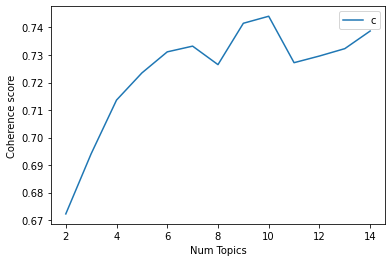

In [49]:
# Show graph
limit=15; start=2; step=1;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [50]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.6723
Num Topics = 3  has Coherence Value of 0.6941
Num Topics = 4  has Coherence Value of 0.7136
Num Topics = 5  has Coherence Value of 0.7235
Num Topics = 6  has Coherence Value of 0.7311
Num Topics = 7  has Coherence Value of 0.7332
Num Topics = 8  has Coherence Value of 0.7265
Num Topics = 9  has Coherence Value of 0.7415
Num Topics = 10  has Coherence Value of 0.7441
Num Topics = 11  has Coherence Value of 0.7272
Num Topics = 12  has Coherence Value of 0.7296
Num Topics = 13  has Coherence Value of 0.7323
Num Topics = 14  has Coherence Value of 0.7387


In [42]:
# Select the model and print the topics
optimal_model = model_list[0]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.035*"love" + 0.025*"lol" + 0.025*"fuck" + 0.021*"view" + 0.018*"sexist" + '
  '0.018*"good" + 0.018*"relevant" + 0.014*"work" + 0.014*"wat" + 0.014*"rig"'),
 (1,
  '0.021*"islam" + 0.015*"rofl" + 0.015*"lie" + 0.015*"awesome" + 0.015*"shit" '
  '+ 0.015*"kat" + 0.012*"bullshit" + 0.012*"stuff" + 0.012*"block" + '
  '0.012*"true"')]


In [43]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)


C:\Users\erajkovic\Anaconda3\envs\tensorflow_env\lib\site-packages\smart_open\smart_open_lib.py:252: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,0.0,0.5,"love, lol, fuck, view, sexist, good, relevant,...",I read them in context.No change in meaning. T...
1,1,0.0,0.5,"love, lol, fuck, view, sexist, good, relevant,...",Now you idiots claim that people who tried to ...
2,2,0.0,0.5,"love, lol, fuck, view, sexist, good, relevant,...","RT Call me sexist, but when I go to an auto pl..."
3,3,0.0,0.5,"love, lol, fuck, view, sexist, good, relevant,...","Wrong, ISIS follows the example of Mohammed an..."
4,4,0.0,0.5,"love, lol, fuck, view, sexist, good, relevant,...",#mkr No No No No No No
5,5,0.0,0.5,"love, lol, fuck, view, sexist, good, relevant,...",RT Saudi preacher who raped and tortured his f...
6,6,0.0,0.5,"love, lol, fuck, view, sexist, good, relevant,...",RT nooo not sexist but most women are bad drivers
7,7,0.0,0.5,"love, lol, fuck, view, sexist, good, relevant,...",Going to make some pancakes.....Dont hve any s...
8,8,0.0,0.5,"love, lol, fuck, view, sexist, good, relevant,...",RT How dare you have feelings is a fantastic w...
9,9,0.0,0.5,"love, lol, fuck, view, sexist, good, relevant,...",RT Theres something wrong when a girl wins Way...


In [44]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.5098,"love, lol, fuck, view, sexist, good, relevant,...","oh, gosh. if only that had been parody."
1,1.0,0.5098,"islam, rofl, lie, awesome, shit, kat, bullshit...",Juxtaposition.


In [45]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()
print(topic_counts)

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = df_topic_sents_keywords[['Dominant_Topic', 'Topic_Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

0.0    16522
1.0      329
Name: Dominant_Topic, dtype: int64


,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"love, lol, fuck, view, sexist, good, relevant,...",16522.0,0.9805
1.0,0.0,"love, lol, fuck, view, sexist, good, relevant,...",329.0,0.0195
2.0,0.0,"love, lol, fuck, view, sexist, good, relevant,...",NaN,NaN
3.0,0.0,"love, lol, fuck, view, sexist, good, relevant,...",NaN,NaN
4.0,0.0,"love, lol, fuck, view, sexist, good, relevant,...",NaN,NaN
...,...,...,...,...
16846.0,0.0,"love, lol, fuck, view, sexist, good, relevant,...",NaN,NaN
16847.0,0.0,"love, lol, fuck, view, sexist, good, relevant,...",NaN,NaN
16848.0,0.0,"love, lol, fuck, view, sexist, good, relevant,...",NaN,NaN
16849.0,0.0,"love, lol, fuck, view, sexist, good, relevant,...",NaN,NaN


In [46]:
df1 = df_dominant_topic[['Dominant_Topic', 'Text']]
print(df1)
df2 = pd.read_csv('../text_twitter_raw.csv')
data = df2.Text.values.tolist()

#remove links
data = [re.sub(r"http\S+", "", sent) for sent in data]

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

df2.Text = data
print(df2)

df1['Text'] == df2['Text']


       Dominant_Topic                                               Text
0                 0.0  I read them in context.No change in meaning. T...
1                 0.0  Now you idiots claim that people who tried to ...
2                 0.0  RT Call me sexist, but when I go to an auto pl...
3                 0.0  Wrong, ISIS follows the example of Mohammed an...
4                 0.0                             #mkr No No No No No No
...               ...                                                ...
16846             0.0  Feeling so sorry for the girls, they should be...
16847             0.0  #MKR pretty good dishes were happy with - OK, ...
16848             0.0  RT Deconstructed lemon tart!....can we please ...
16849             0.0            You are too stupid to talk to. Blocked.
16850             0.0  And before you protest that youre *not* mad, t...

[16851 rows x 2 columns]
                                                    Text     Label
0      I read them in context.N

0        True
1        True
2        True
3        True
4        True
         ... 
16846    True
16847    True
16848    True
16849    True
16850    True
Name: Text, Length: 16851, dtype: bool

In [32]:
mergedStuff = df2
mergedStuff['Dominant_Topic'] = np.where(df1['Text'] == df2['Text'], df1['Dominant_Topic'], np.nan)
#mergedStuff = pd.merge(df1, df2, on=['Text'], how='outer')
print(mergedStuff)

mergedStuff['Dominant_Topic']= mergedStuff['Dominant_Topic']==0
mergedStuff['Label'] = mergedStuff['Label']=='n'
mergedStuff


                                                    Text     Label  \
0      I read them in context.No change in meaning. T...  negative   
1      Now you idiots claim that people who tried to ...  negative   
2      RT Call me sexist, but when I go to an auto pl...  positive   
3      Wrong, ISIS follows the example of Mohammed an...  positive   
4                                 #mkr No No No No No No  negative   
...                                                  ...       ...   
16846  Feeling so sorry for the girls, they should be...  negative   
16847  #MKR pretty good dishes were happy with - OK, ...  negative   
16848  RT Deconstructed lemon tart!....can we please ...  negative   
16849            You are too stupid to talk to. Blocked.  negative   
16850  And before you protest that youre *not* mad, t...  negative   

       Dominant_Topic  
0                 0.0  
1                 0.0  
2                 0.0  
3                 0.0  
4                 1.0  
...            

,Text,Label,Dominant_Topic
0,I read them in context.No change in meaning. T...,False,True
1,Now you idiots claim that people who tried to ...,False,True
2,"RT Call me sexist, but when I go to an auto pl...",False,True
3,"Wrong, ISIS follows the example of Mohammed an...",False,True
4,#mkr No No No No No No,False,False
...,...,...,...
16846,"Feeling so sorry for the girls, they should be...",False,True
16847,"#MKR pretty good dishes were happy with - OK, ...",False,True
16848,RT Deconstructed lemon tart!....can we please ...,False,True
16849,You are too stupid to talk to. Blocked.,False,True


In [33]:
condition = mergedStuff['Dominant_Topic'] == mergedStuff['Label']
mergedStuff['correct'] = np.where(condition, True, False)


In [34]:
print(mergedStuff.loc[mergedStuff.correct == True])

                                             Text  Label  Dominant_Topic  \
4                          #mkr No No No No No No  False           False   
18                                Juxtaposition.   False           False   
70       RT What i learned from #QuestionsForMen   False           False   
142                     Sorry, not into gruesome.  False           False   
206                    oh, darn, you cant? shoot.  False           False   
...                                           ...    ...             ...   
16478  #mkr just isnt the same without and Kelly.  False           False   
16495                         no. i am resisting.  False           False   
16531                            not me :) no hat  False           False   
16665                               #mkr #katmkr   False           False   
16716                             this is in WoD.  False           False   

       correct  
4         True  
18        True  
70        True  
142       True  
20